In [1]:
import os

def download_github_code(path):
    filename = path.rsplit('/')[-1]
    os.system('shred -u {}'.format(filename))
    os.system('wget -q https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/{} -O {}'.format(path, filename))

download_github_code('week06/beheaded_inception3.py')
from beheaded_inception3 import beheaded_inception_v3
os.system('wget -qO- https://github.com/hse-aml/intro-to-dl-pytorch/releases/download/final_project/handout.tar.gz | tar -xzvf - -C .')


0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import json
from collections import Counter
import torch
from tqdm import tqdm_notebook
from random import choice
from tqdm import tqdm
from IPython.display import clear_output
from torch import nn
import torch.nn.functional as F


## This notebook provides code that help us to train image caption model

Our model consists of two parts:
- cnn that encodes image into vector
- rnn that decodes image vector into text decription

In [6]:
%%time

# Load dataset (vectorized images and captions)
#we have alredy preprocessed images into vectors of length 2048
img_codes = np.load("data/image_codes.npy")

#for every image, there is 5 captions
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 225 ms, sys: 467 ms, total: 692 ms
Wall time: 697 ms


We should preprocess captions

In [8]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

#create vocab
vocab = []
for im in captions:
  for cap in im:
    vocab.extend(cap)

# Build a Vocabulary
# Compute word frequencies for each word in captions

word_counts = Counter(vocab)

#preprocess vocabulary
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [9]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

#write function that returns vector representation for text captions

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
class CaptionNet(nn.Module):
    
  def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. . """
        super().__init__()
        
        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        self.lstm_units = lstm_units
        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network.
        self.LSTM = nn.LSTM(emb_size,lstm_units,num_layers = 1,batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        
        self.linear = nn.Linear(lstm_units, n_tokens)
        
  def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        self.LSTM.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        x_emb = self.embedding(captions_ix)

        output, (hn, cn) = self.LSTM(x_emb, (initial_cell[None], initial_hid[None]))
        # compute logits from lstm_out
        output = self.linear(output)
        return output

In [12]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last because we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = criterion(logits_for_next.view(-1, n_tokens), captions_ix_next.view(-1))
    return loss 

## Batch generator

In [13]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.1, random_state=42
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    # get images
    batch_images = img_codes[random_image_ix]
    
    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    # pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), \
        torch.tensor(batch_captions_ix, dtype=torch.int64)

## Train and validate loop

In [15]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
network = CaptionNet(n_tokens)

In [22]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

batch_size = 128
n_epochs = 26
n_batches_per_epoch = 800
n_validation_batches = 85  # how many batches are used for validation after each epoch

for epoch in range(n_epochs):
    
    train_loss = 0
    network.train()
    for _ in tqdm(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        loss_t = compute_loss(network, images, captions)
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches
    
    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


Epoch: 25, train loss: 2.2152976179122925, val loss: 2.398906853619744
Finished!


## Generating caption

The function below creates captions by sampling from probabilities defined by the net.

In [18]:
from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().eval()

def generate_caption(image, network, caption_prefix = ('#START#',), t=1, sample=True, max_len=100):
    network = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
#save  model weights
torch.save(network.state_dict(), 'result.bin')

In [ ]:
#restore model weights
restored_network = CaptionNet(n_tokens)
restored_network.load_state_dict(torch.load('result.bin'))

<All keys matched successfully>

Now we can test our model, by providing an url to an image.

In [19]:
url = 'https://www.forumdaily.com/wp-content/uploads/2021/07/shutterstock_1095001973.jpg'
f_name = url.split('/')[-1]

In [20]:
!wget $url

--2021-09-14 22:26:18--  https://www.forumdaily.com/wp-content/uploads/2021/07/shutterstock_1095001973.jpg
Resolving www.forumdaily.com (www.forumdaily.com)... 69.16.221.30
Connecting to www.forumdaily.com (www.forumdaily.com)|69.16.221.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71313 (70K) [image/jpeg]
Saving to: ‘shutterstock_1095001973.jpg’

shutterstock_109500 100%[===================>]  69.64K  --.-KB/s    in 0.04s   

2021-09-14 22:26:18 (1.90 MB/s) - ‘shutterstock_1095001973.jpg’ saved [71313/71313]



In [ ]:
img = plt.imread(f_name)
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, network, t=5.))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


a cat is sitting on a couch with a laptop .
a cat is laying on a couch with a laptop .
a cat is sitting on a couch with a cat .
a cat laying on a couch with a cat .
a cat is laying on a bed with a cat .


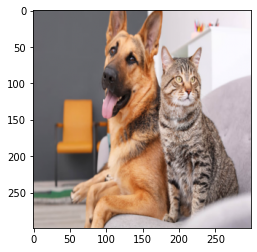

In [21]:
img = plt.imread(f_name)
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, network, t=5.))

a cow with a tag in its ear is sticking its tongue out .
a cow with a tag in its ear is sitting on a fence .
a close up of a cow with a barbed wire fence
a cow with a tag on its nose .
a cow is standing in front of a fence .


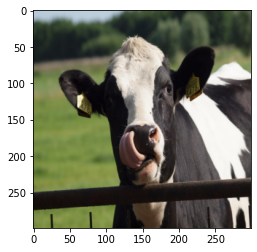

In [ ]:
img = plt.imread(f_name)
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, restored_network, t=5.))

a large jetliner flying through a blue sky .
a large jetliner flying through a blue sky .
a large jetliner flying through a blue sky .
a large jetliner flying through a blue sky .
a large passenger jet flying through a blue sky .


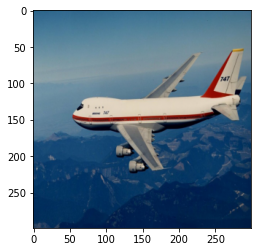

In [ ]:
img = plt.imread(f_name)
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, network, t=5.))

Some more examples:

a kitchen with a sink and a refrigerator
a kitchen with a sink , refrigerator and a refrigerator .
a kitchen with a sink , refrigerator and a microwave .
a kitchen with a sink and a refrigerator
a kitchen with a sink , refrigerator and a stove .


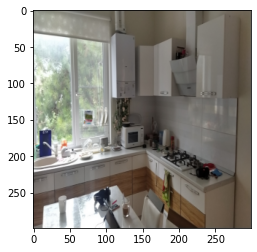

In [ ]:
img = plt.imread('/content/drive/MyDrive/dataset_image_capturing/kitchen.jpg')
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, network, t=5.))

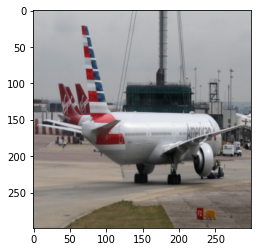

a large air plane on a run way
a large air plane on a run way
a large jetliner sitting on top of a runway .
a large air plane on a run way
a large air plane on a run way


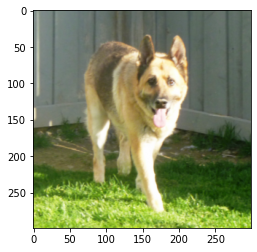

a dog sitting in a chair in front of a window .
a dog is sitting in the grass near a fire hydrant .
a dog sitting in a chair next to a dog .
a dog sitting on a chair in front of a house .
a dog sitting in a chair next to a dog .


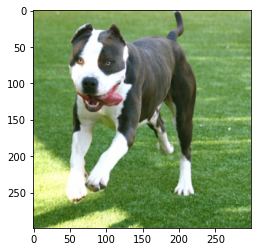

a dog is standing in the grass with a frisbee .
a brown and white dog walking on a grassy field .
a dog standing on the grass with a frisbee in its mouth .
a dog is carrying a frisbee in its mouth .
a dog is standing in the grass with a frisbee .


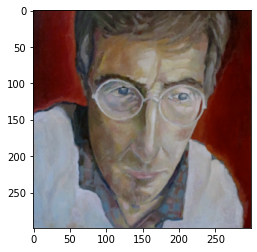

a man with a tie and a tie .
a man with a tie and a tie on .
a man with a red tie and a white beard .
a close up of a person wearing a tie
a man with a tie and a banana .


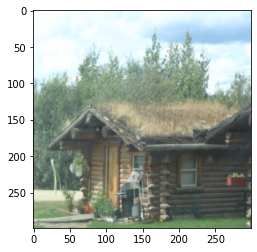

a small house with a house and a small house .
a small house with a large tree in the background .
a small house with a large stone house in the background .
a small bird sitting on a fence next to a building .
a small black and white house with a red house in the background .


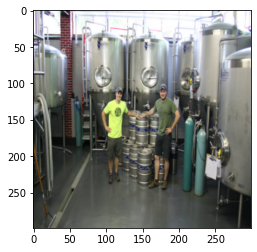

a row of different types of refrigerators are lined up .
a row of white refrigerators with different colors .
a display of various items displayed on a shelf .
a row of different colored toothbrushes in a kitchen .
a row of different colored vases and a glass of water .


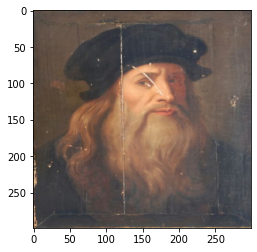

a man in a suit holding a surfboard .
a man with a hat on his head and a black and white dog
a man in a suit holding a surfboard .
a man in a hat is holding a surfboard .
a man wearing a hat and a hat on a horse .


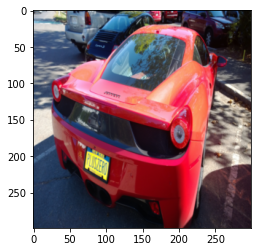

a red and yellow car is parked in a parking meter
a red and white car parked in a parking meter .
a red car is parked in front of a car .
a red and white car parked in front of a parking meter .
a red car is parked in front of a parking meter .


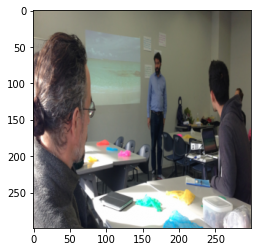

a man and woman are in a kitchen with a man in the background .
a man with a beard is eating a banana .
a man is making a silly face while holding a cell phone .
a man in a kitchen with a woman in a sink .
a man is sitting in a kitchen next to a sink .


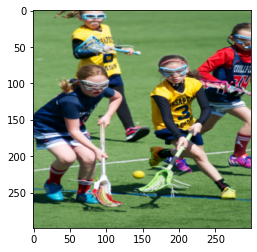

a group of people in a field playing with a frisbee .
a group of people playing soccer in a field .
a group of people playing soccer in a field
a group of people in a field playing frisbee .
a group of people in a field playing with a frisbee .


In [ ]:
for id in range(10):
  img = plt.imread('/content/drive/My Drive/dataset_image_capturing/im_'+str(id)+'.jpg')
  img = resize(img, (299, 299))

  plt.imshow(img)
  plt.show()
  for i in range(5):
      print(generate_caption(img, network, t=5.))